In [13]:
from paths import DATA_DIR, CKPT_FOLDER, PROJECT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv
import cellrank as cr

import scipy
import anndata
from pathlib import Path
import pandas as pd
import seaborn as sns

from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.models.base.geodesic_ae import GeodesicAE
from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

from notebooks.utils import (standardize_adata,
                             add_keys_to_dict,
                             real_reconstructed_cells_adata,
                             add_velocity_to_adata, 
                             compute_velocity_projection, 
                             compute_trajectory, 
                             decode_trajectory)

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Assign biological annotations to the clusters

In [5]:
CLUSTER_ANNOTATIONS = {"7": "ESC",
                      "4": "NE-1",
                      "8": "NE-2",
                      "1": "NP",
                      "10": "NS",
                      "3": "NC",
                      "12": "NS-3",
                      "9": "EC-1",
                      "11": "H",
                      "2": "SMP",
                      "0": "LP-ME",
                      "5": "CP", 
                      "13": "PRE-NE",
                      "6": "EN"}

## Util functions

Read saved anndatas 

In [6]:
adata_latent_vae = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_lib.h5ad")
adata_latent_flat = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")
adata_latent_geodesic = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_geodesic.h5ad")

In [39]:
def get_trajectory_condition(adata, cluster, gene_list, n_x0, idx2time, n_tp=4):
    """
    Starting from cells of a certain cell type, we trace back to previous time points 
    """
    # Take cell from a cluster 
    condition = adata.obs.leiden==cluster
    # Keep only cells from a conditions
    cells_condition = adata[condition]  
    # Indices of cells from a condition 
    indices_cells_condition = np.array(cells_condition.obs.index).astype(np.int32) 
    
    # Collect the indices of the observations mapping to cell type
    indices_lineage = [indices_cells_condition]

    # Loop over ts and collect observations
    for t in range(n_tp, 0, -1):
        t = idx2time[t]
        indices_cells_condition_t = np.array(cells_condition[cells_condition.obs.experimental_time==t].obs.index).astype(np.int32)
        tmp_indices = indices_cells_condition_t - n_x0
        indices_lineage.append(tmp_indices.copy())
        cells_condition = adata[np.concatenate(indices_lineage)]

    indices_lineage = np.concatenate(indices_lineage)
    adata_lineage = adata[indices_lineage]

    # Collect indices of genes of interest
    gene_to_id = {}
    list_genes = list(adata.var.gene_name)
    for gene in gene_list:
        gene_to_id[gene] = list_genes.index(gene)
    return adata_lineage, gene_to_id
                    
def plot_violin_condition(anndata_list, gene_name, idx, methods):
    """
    Cell types on the x axis and gene expression on the y-axis
    """
    # Extract Leiden cluster assignments from each anndata object
    leiden_clusters = [adata.obs['leiden'] for adata in anndata_list]
    
    # Extract gene expression data
    gene_expression = []
    for adata in anndata_list:
        try:
            gene_expression.append(adata[:, idx].X.ravel())
        except:
            gene_expression.append(adata[:, idx].X.A.ravel())
    
    # Method names
    methods_names = []
    for i, method_name in enumerate(methods):
        methods_names += [method_name for _ in range(len(gene_expression[i]))]
    
    # Concatenate data
    leiden_clusters = np.concatenate(leiden_clusters)
    gene_expression = np.concatenate(gene_expression)
    method = np.array(methods_names)
    
    # Create a violin plot
    plt.figure(figsize=(8, 3))
    plotting_dict = {"gene_expression": gene_expression, 
                     "leiden_clusters": leiden_clusters,
                     "method": method}
 
    plotting_dict["leiden_clusters"] = [CLUSTER_ANNOTATIONS[i] for i in plotting_dict["leiden_clusters"]]
    
    ax = sns.violinplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
             width=0.8, palette="vlag", hue_order=["NB-VAE", "FlatVI", "GAE", "Real"])
    
    # Add in points to show each observation
    # sns.stripplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
    #               size=4, color=".3", linewidth=0, dodge=0.2, legend=False)
    # sns.stripplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
    #               size=4, color=".3", linewidth=0, dodge=0.2, legend=False)

    plt.ylabel("log(GEX)")
    plt.xlabel("cell type")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(gene_name)
    plt.show()

# Analysis

Initialize datamodules for all three models 

In [8]:
datamodule_kwargs_vae = {'path': DATA_DIR / "eb" / "flat" / "eb_lib.h5ad",
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad",
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

datamodule_kwargs_geodesic = {'path': DATA_DIR / "eb" / "flat" / "eb_geodesic.h5ad",
                              'x_layer': 'X_latents',
                              'time_key': 'experimental_time', 
                              'use_pca': False, 
                              'n_dimensions': None, 
                              'train_val_test_split': [0.9, 0.1], 
                              'num_workers': 2, 
                              'batch_size': 512, 
                               'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)
datamodule_geodesic = TrajectoryDataModule(**datamodule_kwargs_geodesic)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

In [9]:
net_hparams = {"dim": datamodule_vae.dim,
                "w": 64,
                "time_varying": True}

net_vae = MLP(**net_hparams).to(device)
net_flat = MLP(**net_hparams).to(device)
net_geodesic = MLP(**net_hparams).to(device)

CFM model 

In [10]:
cfm_kwargs = {'ot_sampler': 'exact', 
               'sigma': 0.1, 
               'use_real_time': False, 
               'lr': 0.001, 
               'antithetic_time_sampling': True}

cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)
cfm_geodesic = CFMLitModule(net=net_geodesic, datamodule=datamodule_geodesic, **cfm_kwargs).to(device)

In [14]:
CKPT_FOLDER = Path("/home/icb/alessandro.palma/environment/scCFM/project_dir/checkpoints/")

In [16]:
cfm_vae.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb_old" / "best_cfm_model_eb.ckpt")["state_dict"])
cfm_flat.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb_old" / "best_cfm_model_flat_eb.ckpt")["state_dict"])
cfm_geodesic.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb_old" / "best_cfm_model_geodesic_eb.ckpt")["state_dict"])

<All keys matched successfully>

**Decoded trajectories**

In [17]:
datamodule={'path': DATA_DIR / "eb" / "processed" / "eb_phate.h5ad", 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 512, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

Initialize variational autoencoders

In [18]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           "trainable_c": False,
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}
    
geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [19]:
# Initialize vae and geometric vae
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)
geodesic_ae = GeodesicAE(**geodesic).to(cfm_vae.device)

In [20]:
# Load state dicts and put in eval mode 
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric_lib.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geodesic_ae.ckpt")["state_dict"])

vae.eval()
geometric_vae.eval()
geodesic_ae.eval()

GeodesicAE(
  (encoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1241, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=256, out_features=1241, bias=True)
        (1): BatchNorm1d(1241, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_mu_lib): Linear(in_features=256, out_features=1241, bias=True)
  (latent_layer): Linear(in_features=256, out_features=10, bias=True)
  (criterion): MSELoss()
)

Compute the trajectories 

In [21]:
#Pick time 0 observations
X_adata_t0_vae = torch.from_numpy(adata_latent_vae[adata_latent_vae.obs["experimental_time"]==0].X).to(device)
X_adata_t0_flat = torch.from_numpy(adata_latent_flat[adata_latent_flat.obs["experimental_time"]==0].X).to(device)
X_adata_t0_geodesic = torch.from_numpy(adata_latent_geodesic[adata_latent_geodesic.obs["experimental_time"]==0].X).to(device)

#Library values of observations at time 0
l_t0_vae = adata_latent_vae.obs.loc[adata_latent_vae.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_flat = adata_latent_flat.obs.loc[adata_latent_flat.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_geodesic = adata_latent_geodesic.obs.loc[adata_latent_geodesic.obs["experimental_time"]==0, "log_library_size"].to_numpy()

l_t0_vae = torch.from_numpy(l_t0_vae).to(device)
l_t0_flat = torch.from_numpy(l_t0_flat).to(device)
l_t0_geodesic = torch.from_numpy(l_t0_geodesic).to(device)

In [22]:
# Number of observations at x0
n_x0 = X_adata_t0_vae.shape[0]

In [23]:
# Collect data trajectories
mu_traj_vae, x_traj_vae, times_traj_vae = decode_trajectory(X_adata_t0_vae,
                                                            l_t0_vae,
                                                            cfm_vae,
                                                            vae,
                                                            idx2time, 
                                                            device, 
                                                            use_real_time=False,
                                                            append_last=True,
                                                            keep_time_d=False, 
                                                            model_type="vae")

mu_traj_flat, x_traj_flat, times_traj_flat = decode_trajectory(X_adata_t0_flat,
                                                               l_t0_flat,
                                                               cfm_flat,
                                                               geometric_vae,
                                                               idx2time, 
                                                               device, 
                                                               use_real_time=False, 
                                                               append_last=True,
                                                               keep_time_d=False, 
                                                               model_type="vae")

mu_traj_geodesic, x_traj_geodesic, times_traj_geodesic = decode_trajectory(X_adata_t0_geodesic,
                                                                               l_t0_geodesic,
                                                                               cfm_geodesic,
                                                                               geodesic_ae,
                                                                               idx2time, 
                                                                               device, 
                                                                               use_real_time=False, 
                                                                               append_last=True,
                                                                               keep_time_d=False, 
                                                                               model_type="geodesic_ae")

# Real time cells (for plotting)
times_traj_vae = pd.DataFrame(times_traj_vae)
times_traj_flat = pd.DataFrame(times_traj_flat)
times_traj_geodesic = pd.DataFrame(times_traj_geodesic)

times_traj_vae.columns = ["experimental_time"]
times_traj_flat.columns = ["experimental_time"]
times_traj_geodesic.columns = ["experimental_time"]

In [24]:
# Create anndatas
adata_x_traj_vae = anndata.AnnData(X=x_traj_vae.detach().numpy(), 
                                     obs=times_traj_vae)
adata_x_traj_flat = anndata.AnnData(X=x_traj_flat.detach().numpy(),
                                      obs=times_traj_flat)
adata_x_traj_geodesic = anndata.AnnData(X=x_traj_geodesic.detach().numpy(),
                                      obs=times_traj_geodesic)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


We now have simulated datasets. We read the true datasets and visualize it 

In [25]:
adata_eb_original = sc.read_h5ad(DATA_DIR / "eb" / "processed" / "eb_phate.h5ad")

Annotate genes

In [26]:
adata_x_traj_vae.var = adata_eb_original.var.copy()
adata_x_traj_flat.var = adata_eb_original.var.copy()
adata_x_traj_geodesic.var = adata_eb_original.var.copy()

Preprocess

In [27]:
#log1p and neighbors calculation
sc.pp.log1p(adata_x_traj_vae)
sc.pp.log1p(adata_x_traj_flat)

sc.tl.pca(adata_x_traj_vae)
sc.tl.pca(adata_x_traj_flat)
sc.tl.pca(adata_x_traj_geodesic)

sc.pp.neighbors(adata_x_traj_vae)
sc.pp.neighbors(adata_x_traj_flat)
sc.pp.neighbors(adata_x_traj_geodesic)

sc.tl.umap(adata_x_traj_vae)
sc.tl.umap(adata_x_traj_flat)
sc.tl.umap(adata_x_traj_geodesic)

In [28]:
# Transfer labels from the data to the simulated cells 
sc.tl.ingest(adata_x_traj_vae, adata_eb_original, obs="leiden", embedding_method="umap")
sc.tl.ingest(adata_x_traj_flat, adata_eb_original, obs="leiden", embedding_method="umap")
sc.tl.ingest(adata_x_traj_geodesic, adata_eb_original, obs="leiden", embedding_method="umap")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


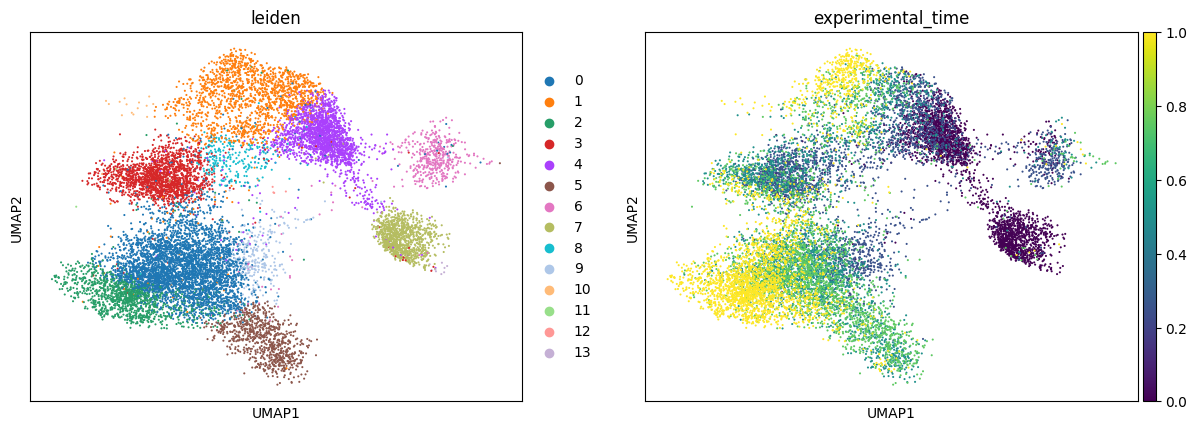

In [29]:
sc.pl.umap(adata_x_traj_flat, color=["leiden", "experimental_time"] )

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


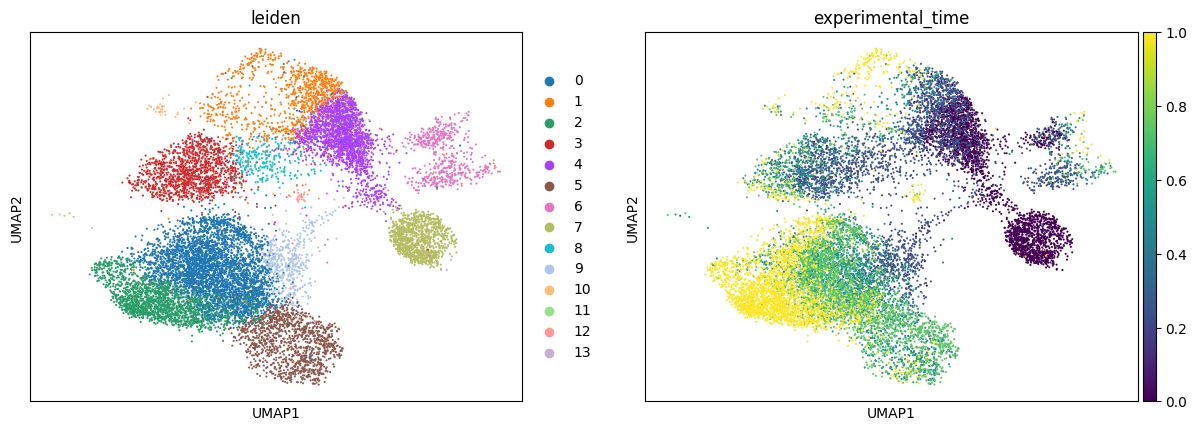

In [30]:
sc.pl.umap(adata_x_traj_vae, color=["leiden", "experimental_time"])

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


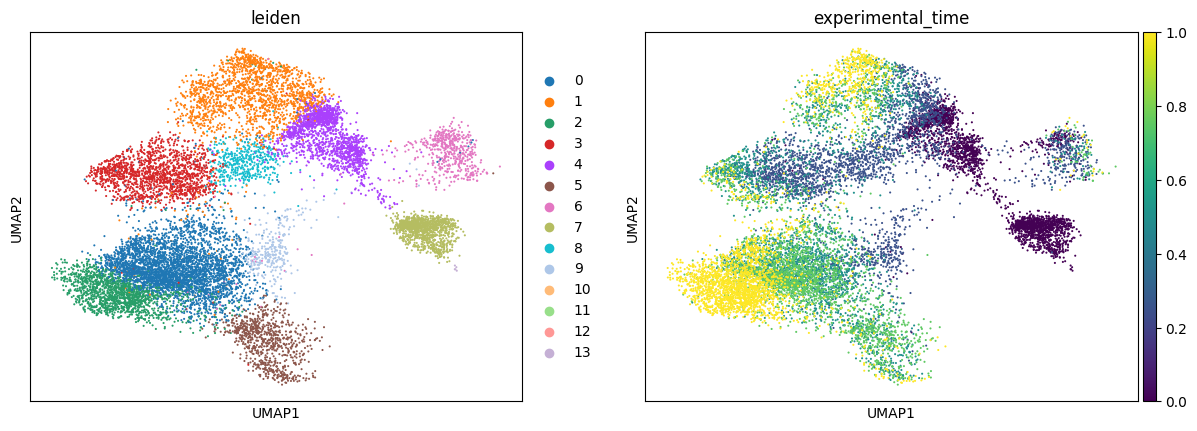

In [31]:
sc.pl.umap(adata_x_traj_geodesic, color=["leiden", "experimental_time"])

# Reset indices 

In [32]:
adata_x_traj_flat.var = adata_x_traj_flat.var.reset_index()
adata_x_traj_vae.var = adata_x_traj_vae.var.reset_index()
adata_x_traj_geodesic.var = adata_x_traj_geodesic.var.reset_index()
adata_eb_original.var = adata_eb_original.var.reset_index()

# Perform lineage analysis

In [33]:
adata_x_traj_geodesic.obs.leiden.value_counts()

leiden
0     3648
4     1695
1     1651
3     1509
2     1508
7     1170
5      775
6      516
8      454
9      313
13       6
10       0
11       0
12       0
Name: count, dtype: int64

### Neuronal

In [34]:
# Flat
X_neuronal_flat_ct, genes_neuronal_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                    '10', 
                                                                    ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1","NR2F1"], 
                                                                    n_x0=n_x0,
                                                                    idx2time=idx2time,
                                                                    n_tp=4)
X_neuronal_flat_ct = X_neuronal_flat_ct[X_neuronal_flat_ct.obs.leiden.isin(['7', '4', '1', '10'])]

# VAE
X_neuronal_vae_ct, _ = get_trajectory_condition(adata_x_traj_vae, 
                                               '10', 
                                                ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1", "NR2F1"],
                                                n_x0=n_x0,
                                                idx2time=idx2time,
                                                n_tp=4)
X_neuronal_vae_ct = X_neuronal_vae_ct[X_neuronal_vae_ct.obs.leiden.isin(['7', '4', '1', '10'])]

# Geodesic
X_neuronal_geodesic_ct, _ = get_trajectory_condition(adata_x_traj_geodesic, 
                                                       '1', 
                                                        ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1", "NR2F1"],
                                                        n_x0=n_x0,
                                                        idx2time=idx2time,
                                                        n_tp=4)
X_neuronal_geodesic_ct = X_neuronal_geodesic_ct[X_neuronal_geodesic_ct.obs.leiden.isin(['7', '4', '1'])]

In [35]:
adata_eb_original_neuronal = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '4', '1', '10'])]
adata_eb_original_neuronal.uns['iroot'] = np.flatnonzero(adata_eb_original_neuronal.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_neuronal)
adata_eb_original_neuronal = adata_eb_original_neuronal[adata_eb_original_neuronal.obs.sort_values(by="dpt_pseudotime").index]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


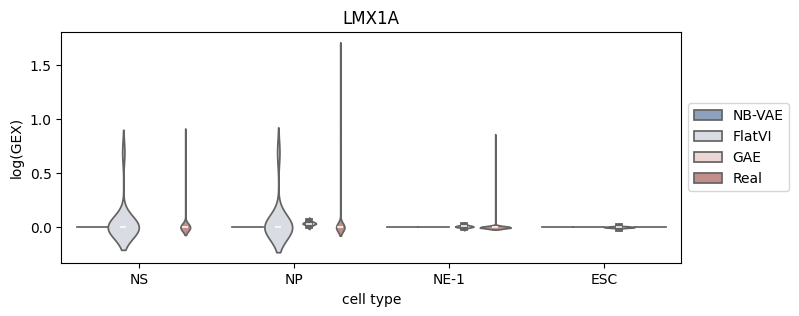

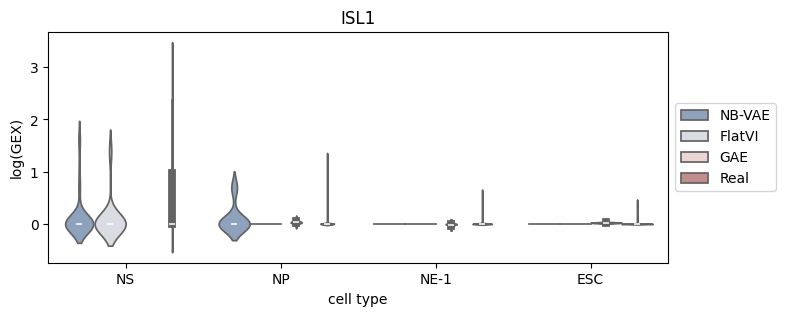

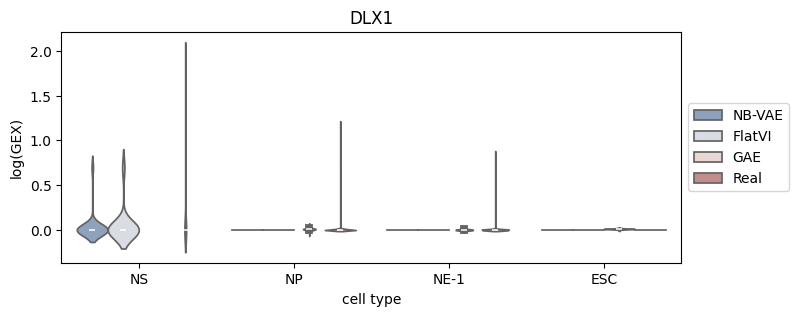

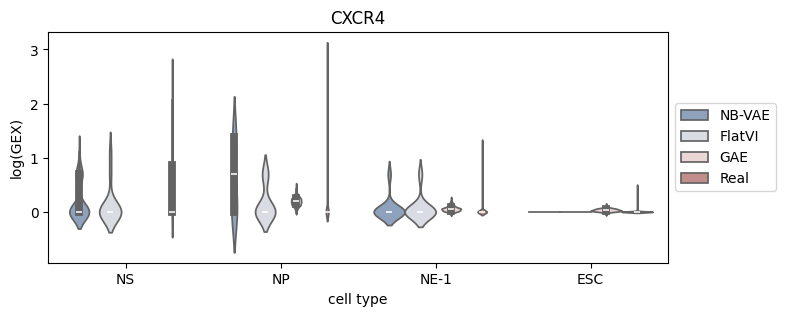

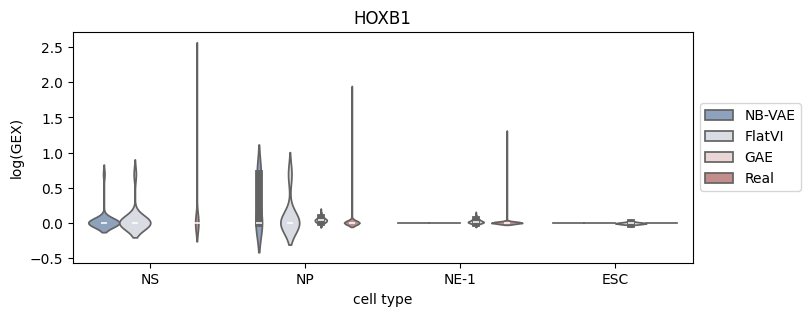

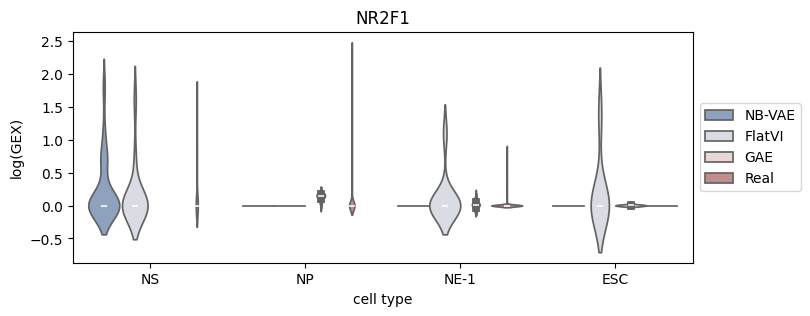

In [40]:
for gene, gene_id in genes_neuronal_cells.items():
    plot_violin_condition([X_neuronal_flat_ct, X_neuronal_vae_ct, X_neuronal_geodesic_ct, adata_eb_original_neuronal],
                            gene, 
                            gene_id,
                            methods=["FlatVI", "NB-VAE", "GAE","Real"])

## Endoderm

In [41]:
X_endoderm_flat_ct, genes_endoderm_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                  '6', 
                                                                  ["SOX17", "FOXA2", "CDX2", "GATA3"], 
                                                                  n_x0=n_x0,
                                                                  idx2time=idx2time,
                                                                  n_tp=4)
X_endoderm_flat_ct = X_endoderm_flat_ct[X_endoderm_flat_ct.obs.leiden.isin(['7', '13', '4', '6'])]

X_endoderm_vae_ct, _ = get_trajectory_condition(adata_x_traj_vae,
                                                 '6', 
                                                ["SOX17", "FOXA2", "CDX2", "GATA3"],
                                                n_x0=n_x0,
                                                idx2time=idx2time,
                                                n_tp=4)
X_endoderm_vae_ct = X_endoderm_vae_ct[X_endoderm_vae_ct.obs.leiden.isin(['7', '13', '4', '6'])]

X_endoderm_geodesic_ct, _ = get_trajectory_condition(adata_x_traj_geodesic,
                                                         '6', 
                                                        ["SOX17", "FOXA2", "CDX2", "GATA3"],
                                                        n_x0=n_x0,
                                                        idx2time=idx2time,
                                                        n_tp=4)
X_endoderm_geodesic_ct = X_endoderm_geodesic_ct[X_endoderm_geodesic_ct.obs.leiden.isin(['7', '13', '4', '6'])]

In [42]:
adata_eb_original_endoderm = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '13', '4', '6'])]
adata_eb_original_endoderm.uns['iroot'] = np.flatnonzero(adata_eb_original_endoderm.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_endoderm)
adata_eb_original_endoderm = adata_eb_original_endoderm[adata_eb_original_endoderm.obs.sort_values(by="dpt_pseudotime").index]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


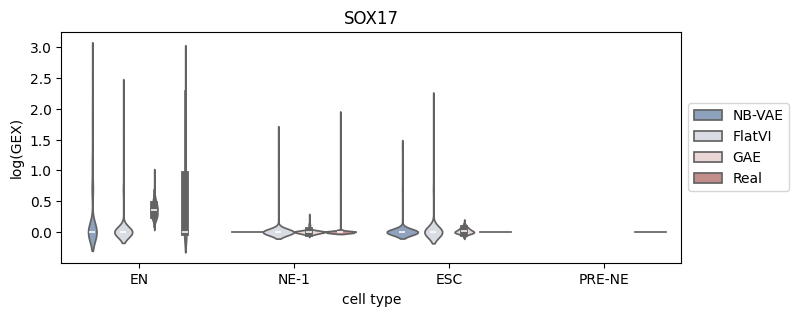

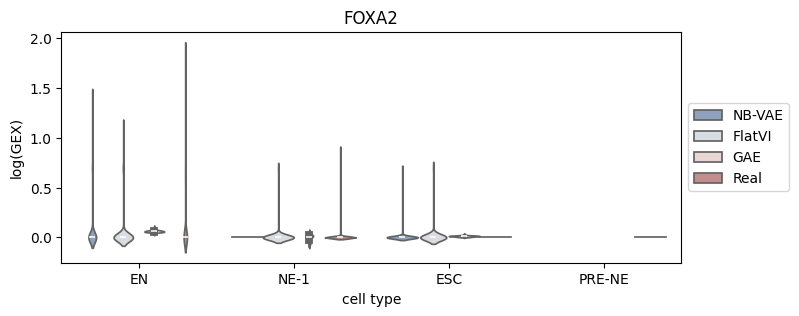

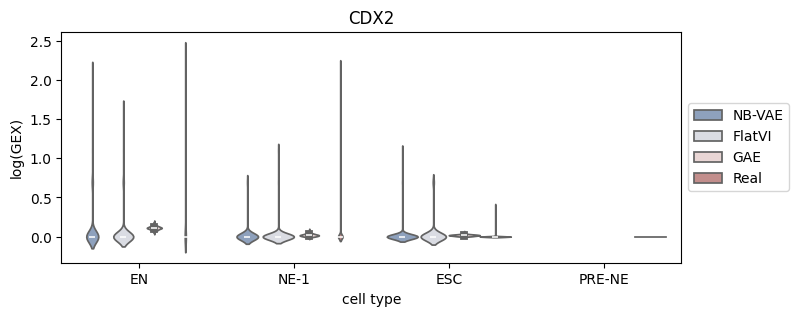

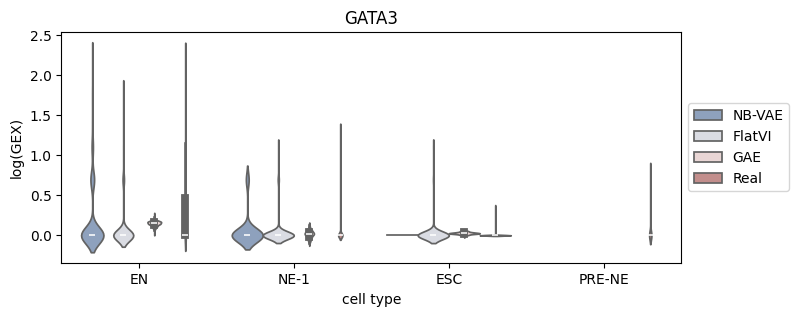

In [43]:
for gene, gene_id in genes_endoderm_cells.items():
    plot_violin_condition([X_endoderm_flat_ct, X_endoderm_vae_ct, X_endoderm_geodesic_ct,adata_eb_original_endoderm],
                            gene, 
                            gene_id,
                            methods=["FlatVI", "NB-VAE", "GAE", "Real"])

### Neural crest

In [44]:
X_neural_crest_cells_flat_ct, genes_neural_crest_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                                  '3', 
                                                                                  ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                                                                  n_x0=n_x0,
                                                                                  idx2time=idx2time,
                                                                                  n_tp=4)
X_neural_crest_cells_flat_ct = X_neural_crest_cells_flat_ct[X_neural_crest_cells_flat_ct.obs.leiden.isin(['7', '4', '8', '3'])]


X_neural_crest_cells_vae_ct, _ = get_trajectory_condition(adata_x_traj_vae, 
                                                          '3', 
                                                          ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                                          n_x0=n_x0,
                                                          idx2time=idx2time,
                                                          n_tp=4)
X_neural_crest_cells_vae_ct = X_neural_crest_cells_vae_ct[X_neural_crest_cells_vae_ct.obs.leiden.isin(['7', '4', '8', '3'])]


X_neural_crest_cells_geodesic_ct, _ = get_trajectory_condition(adata_x_traj_geodesic, 
                                                          '3', 
                                                          ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                                          n_x0=n_x0,
                                                          idx2time=idx2time,
                                                          n_tp=4)
X_neural_crest_cells_geodesic_ct = X_neural_crest_cells_geodesic_ct[X_neural_crest_cells_geodesic_ct.obs.leiden.isin(['7', '4', '8', '3'])]

In [45]:
adata_eb_original_neural_crest = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '4', '8', '3'])]
adata_eb_original_neural_crest.uns['iroot'] = np.flatnonzero(adata_eb_original_neural_crest.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_neural_crest)
adata_eb_original_neural_crest = adata_eb_original_neural_crest[adata_eb_original_neural_crest.obs.sort_values(by="dpt_pseudotime").index]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


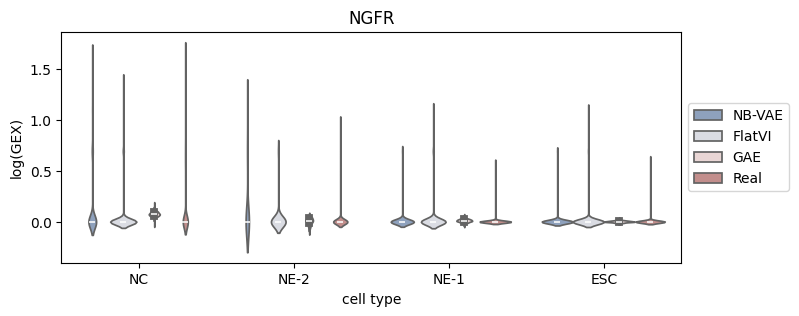

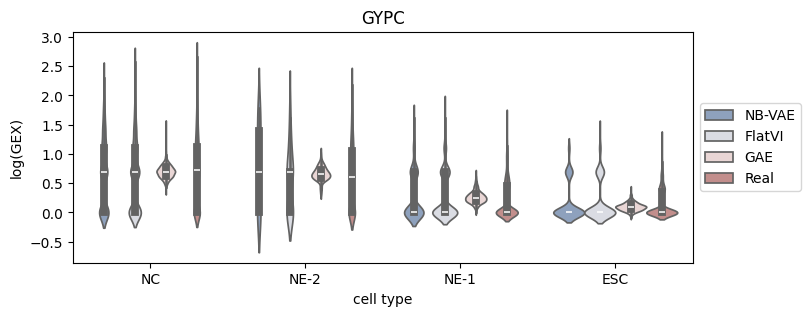

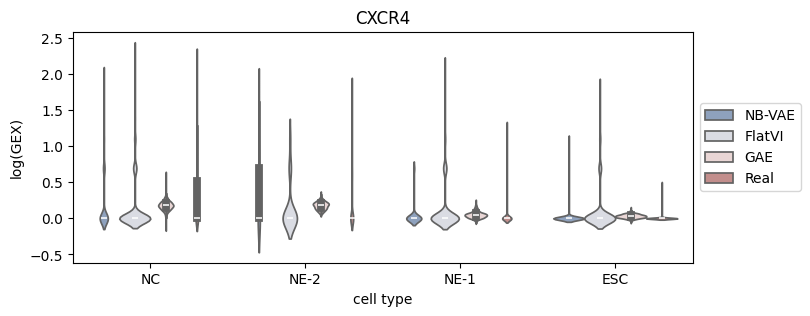

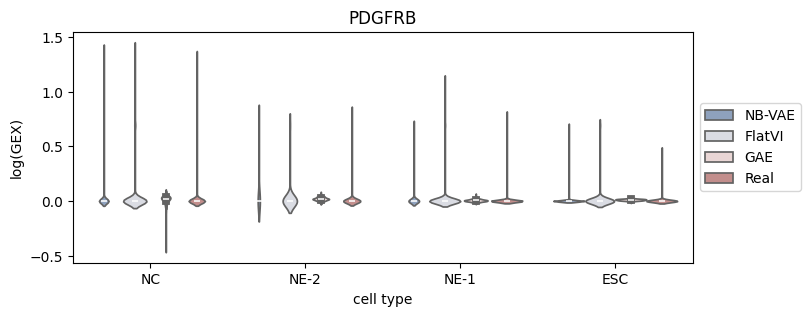

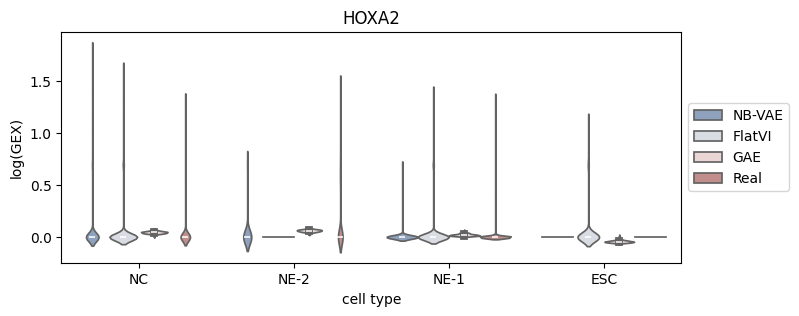

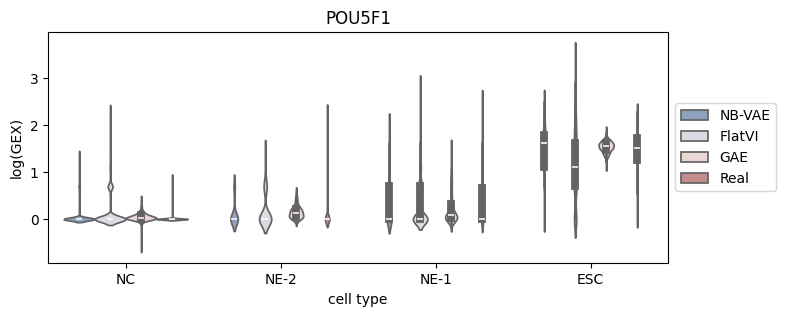

In [46]:
for gene, gene_id in genes_neural_crest_cells.items():
    plot_violin_condition([X_neural_crest_cells_flat_ct, X_neural_crest_cells_vae_ct, X_neural_crest_cells_geodesic_ct, adata_eb_original_neural_crest],
                            gene, 
                            gene_id,
                            methods=["FlatVI", "NB-VAE", "GAE", "Real"])

### Cardiac

In [47]:
X_cardiac_flat_ct, genes_cardiac_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                  '5', 
                                                                  ["GATA6", "GATA5", "HAND1", "TNNT2"], 
                                                                  n_x0=n_x0,
                                                                  idx2time=idx2time,
                                                                  n_tp=4)
X_cardiac_flat_ct = X_cardiac_flat_ct[X_cardiac_flat_ct.obs.leiden.isin(['7', '9', '5'])]

X_cardiac_vae_ct, _ = get_trajectory_condition(adata_x_traj_vae,
                                                '5', 
                                                ["GATA6", "GATA5", "HAND1", "TNNT2"],
                                                n_x0=n_x0,
                                                idx2time=idx2time,
                                                n_tp=4)
X_cardiac_vae_ct = X_cardiac_vae_ct[X_cardiac_vae_ct.obs.leiden.isin(['7', '9', '5'])]


X_cardiac_geodesic_ct, _ = get_trajectory_condition(adata_x_traj_geodesic,
                                                '5', 
                                                ["GATA6", "GATA5", "HAND1", "TNNT2"],
                                                n_x0=n_x0,
                                                idx2time=idx2time,
                                                n_tp=4)
X_cardiac_geodesic_ct = X_cardiac_geodesic_ct[X_cardiac_geodesic_ct.obs.leiden.isin(['7', '9', '5'])]

In [55]:
adata_eb_original_cardiac = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '9', '5'])]
adata_eb_original_cardiac.uns['iroot'] = np.flatnonzero(adata_eb_original_cardiac.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_cardiac)
adata_eb_original_cardiac = adata_eb_original_cardiac[adata_eb_original_cardiac.obs.sort_values(by="dpt_pseudotime").index]
adata_eb_original_cardiac.obs["cell type"] = [CLUSTER_ANNOTATIONS[i] for i in adata_eb_original_cardiac.obs.leiden]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_3813575/1861571631.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_eb_original_cardiac.obs["cell type"] = [CLUSTER_ANNOTATIONS[i] for i in adata_eb_original_cardiac.obs.leiden]


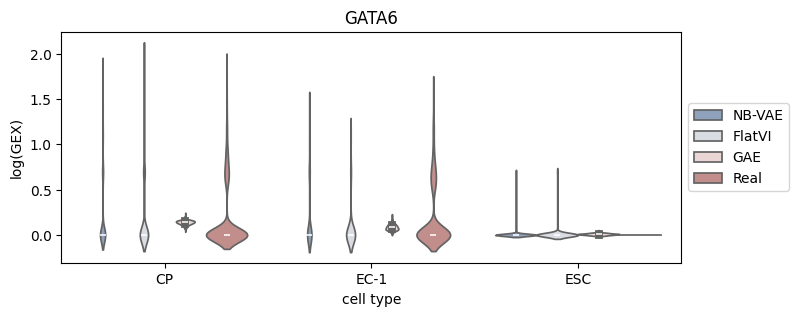

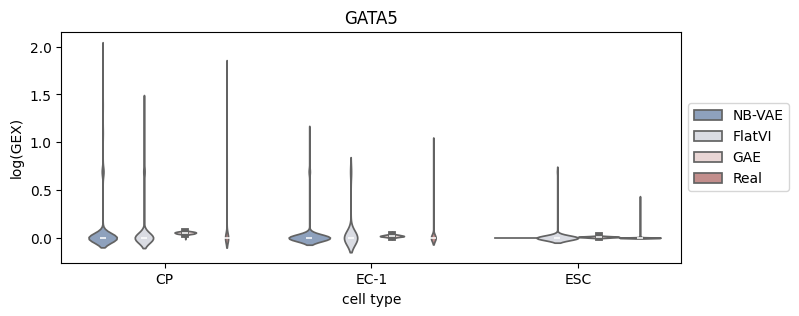

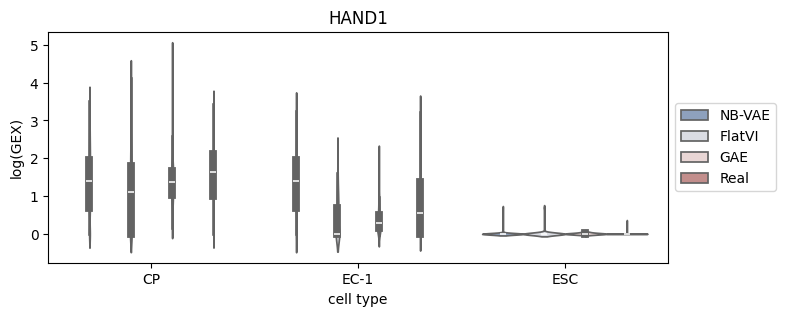

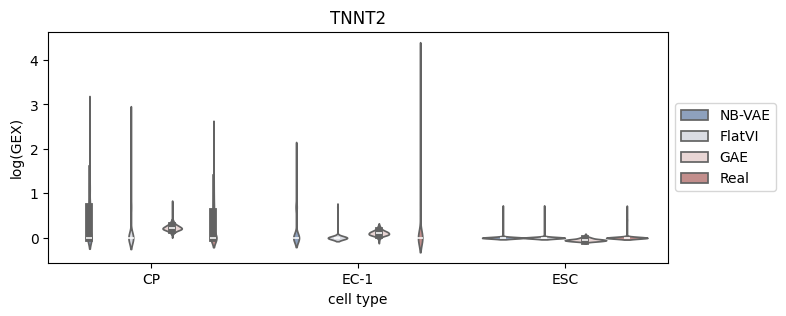

In [56]:
for gene, gene_id in genes_cardiac_cells.items():
    plot_violin_condition([X_cardiac_flat_ct, X_cardiac_vae_ct, X_cardiac_geodesic_ct, adata_eb_original_cardiac],
                            gene, 
                            gene_id,
                            methods=["FlatVI", "NB-VAE", "GAE", "Real"])

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


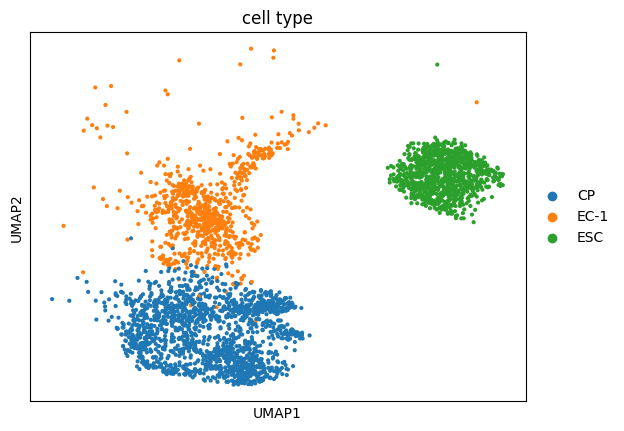

In [57]:
sc.pl.umap(adata_eb_original_cardiac, color="cell type")

## Plot lineage drivers 

In [58]:
sc.set_figure_params(scanpy=True,
                         dpi=120, 
                         dpi_save=150,
                         frameon=False, 
                         vector_friendly=True,
                         fontsize=14, 
                         figsize=None,
                         color_map=None, 
                         format='pdf', 
                         facecolor=None, 
                         transparent=False, 
                         ipython_format='png2x')

In [59]:
adata_x_traj_flat.var = adata_x_traj_flat.var.set_index("gene_name")       
adata_x_traj_vae.var = adata_x_traj_vae.var.set_index("gene_name")
adata_x_traj_geodesic.var = adata_x_traj_geodesic.var.set_index("gene_name")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(va

### Neural Crest drivers

In [60]:
adata_eb_original_neural_crest.var = adata_eb_original_neural_crest.var.set_index("gene_name")
X_neural_crest_cells_flat_ct.var = adata_eb_original_neural_crest.var
X_neural_crest_cells_vae_ct.var = adata_eb_original_neural_crest.var
X_neural_crest_cells_geodesic_ct.var = adata_eb_original_neural_crest.var

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/annda

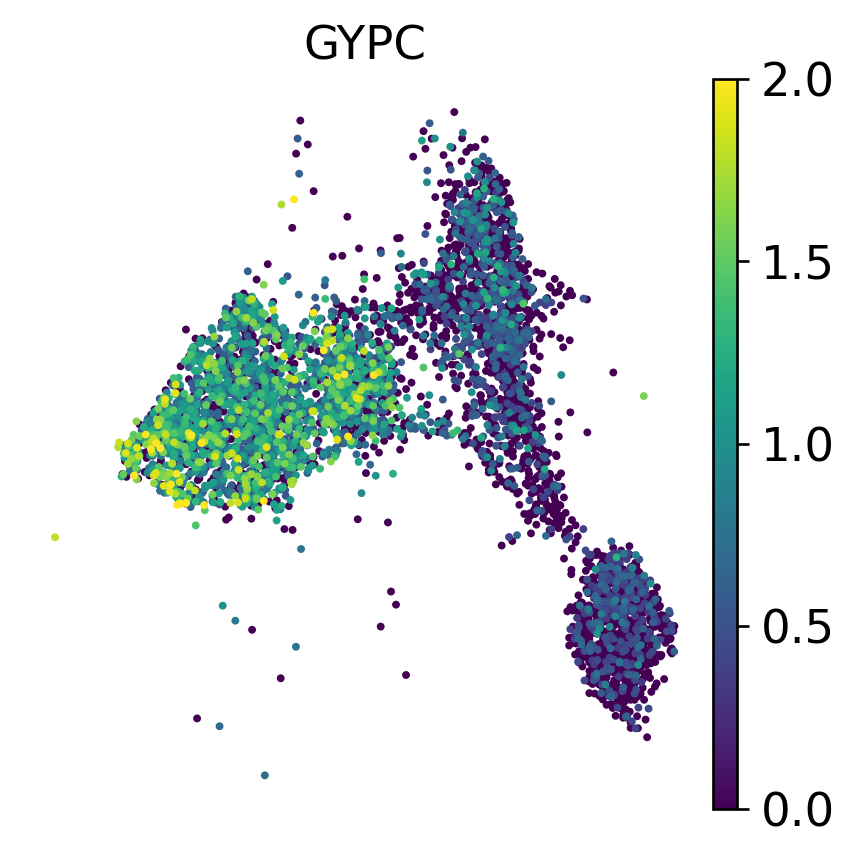

In [61]:
sc.pl.umap(adata_eb_original_neural_crest, color="GYPC", vmin=0, vmax=2)

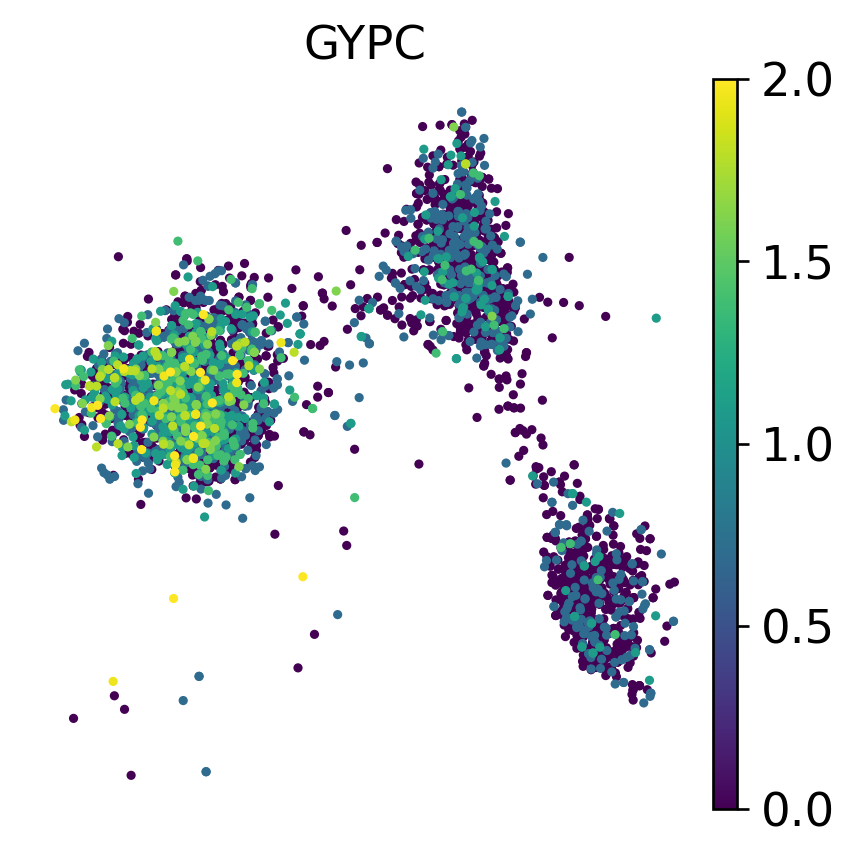

In [62]:
sc.pl.umap(X_neural_crest_cells_flat_ct, color="GYPC", vmin=0, vmax=2)

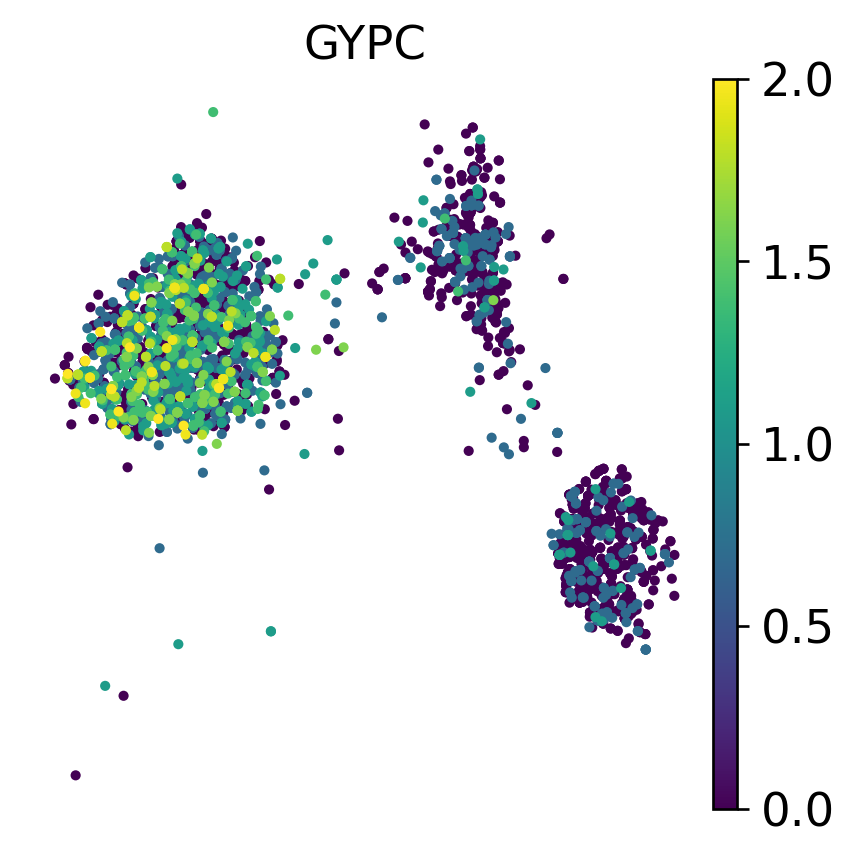

In [63]:
sc.pl.umap(X_neural_crest_cells_vae_ct, color="GYPC", vmin=0, vmax=2)

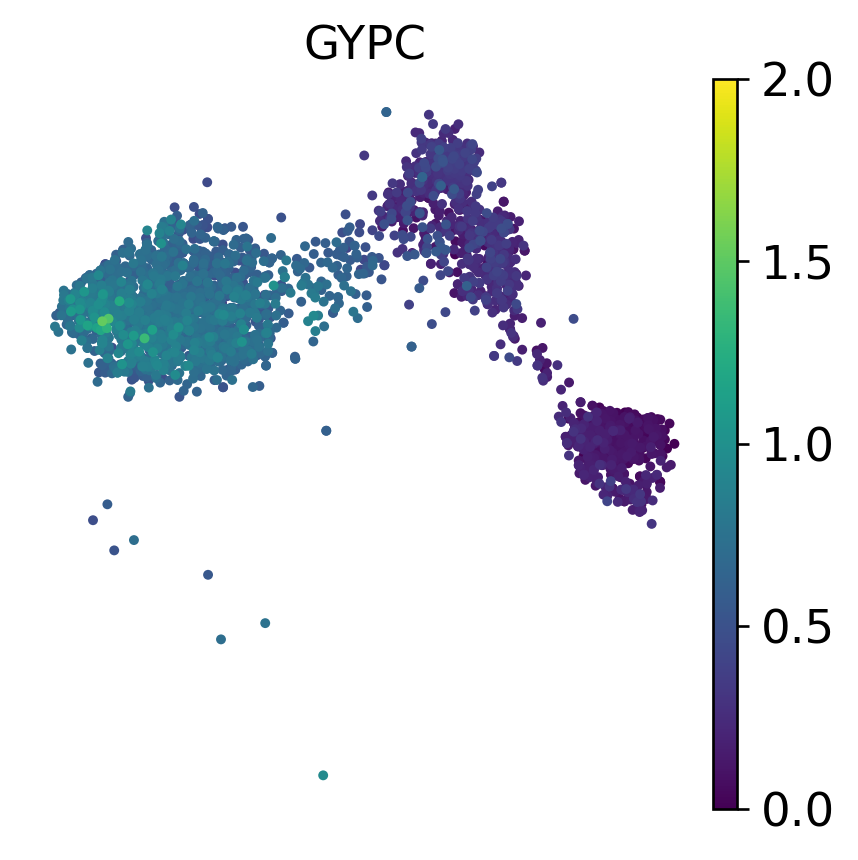

In [64]:
sc.pl.umap(X_neural_crest_cells_geodesic_ct, color="GYPC", vmin=0, vmax=2)

### Cardiac drivers

In [65]:
adata_eb_original_cardiac.var = adata_eb_original_cardiac.var.set_index("gene_name")
X_cardiac_vae_ct.var = adata_eb_original_cardiac.var
X_cardiac_flat_ct.var = adata_eb_original_cardiac.var
X_cardiac_geodesic_ct.var = adata_eb_original_cardiac.var

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/annda

In [76]:
adata_eb_original_cardiac

AnnData object with n_obs × n_vars = 3344 × 1241
    obs: 'sample_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'leiden', 'dpt_pseudotime', '1d-phate', '1d-phate-normalized', 'experimental_time', 'cell type'
    var: 'index', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'gene_id', 'gene_name_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'diffmap_evals', 'hvg', 'iroot', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_labels_colors', 'tsne', 'umap', 'cell type_colors'
    obsm: 'X_diffmap', 'X_pca', 'X_phate', 'X_phate_normalized', 'X_phate_real_time', 'X_phate_time', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'X_log', 'X_norm'
    obsp: 'connectivities', 'distances'

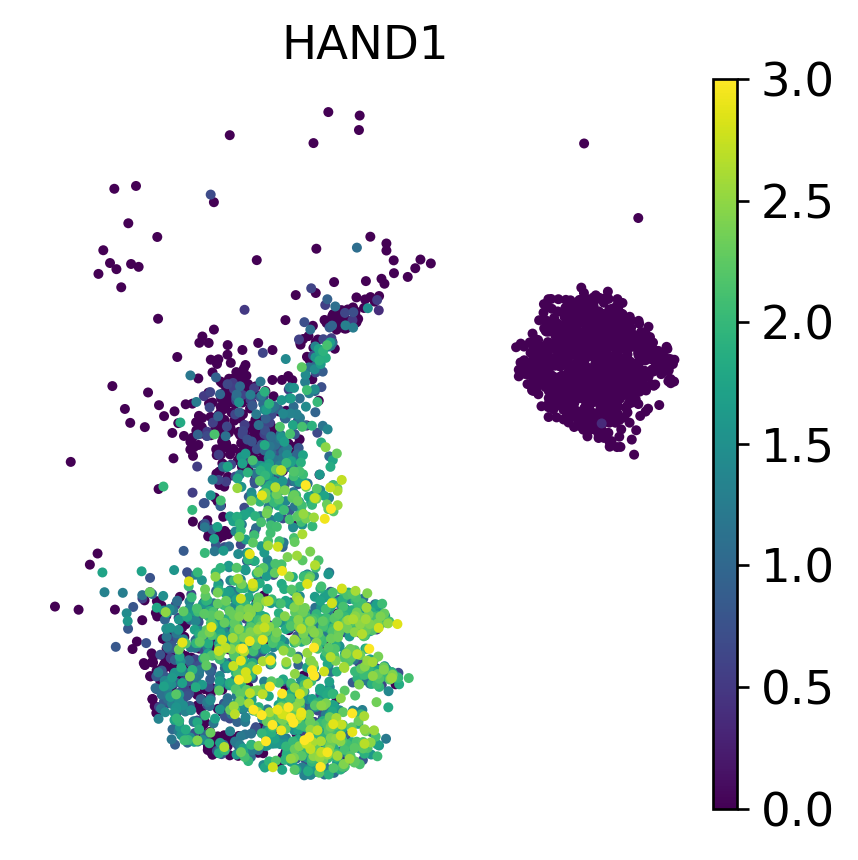

In [66]:
sc.pl.umap(adata_eb_original_cardiac, color="HAND1", vmin=0, vmax=3)

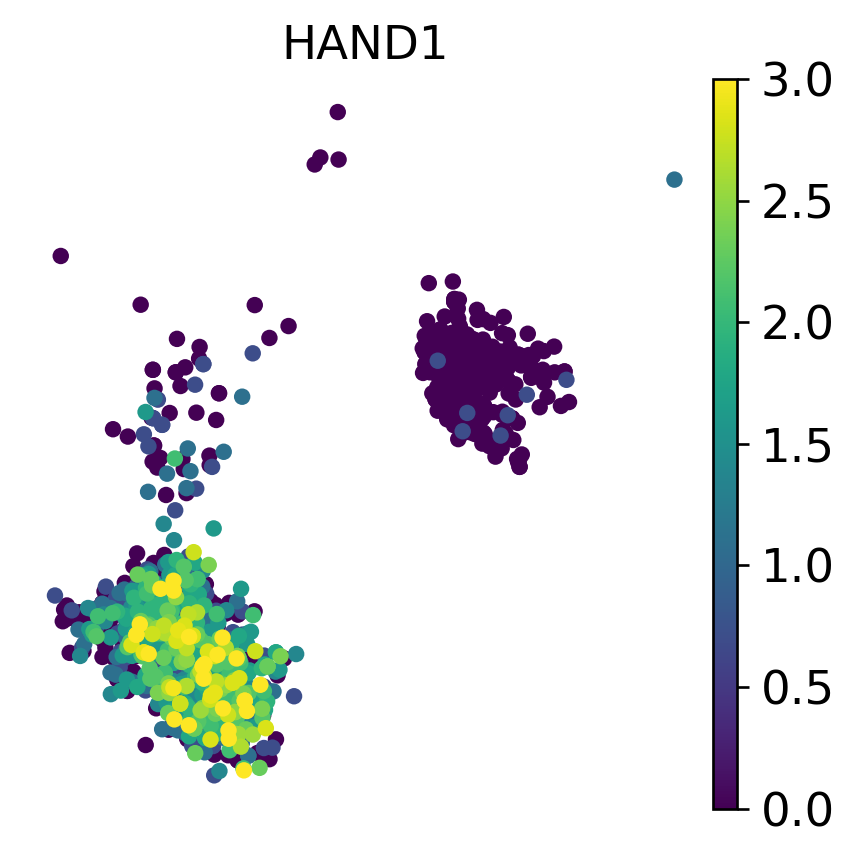

In [67]:
sc.pl.umap(X_cardiac_flat_ct, color="HAND1", vmin=0, vmax=3)

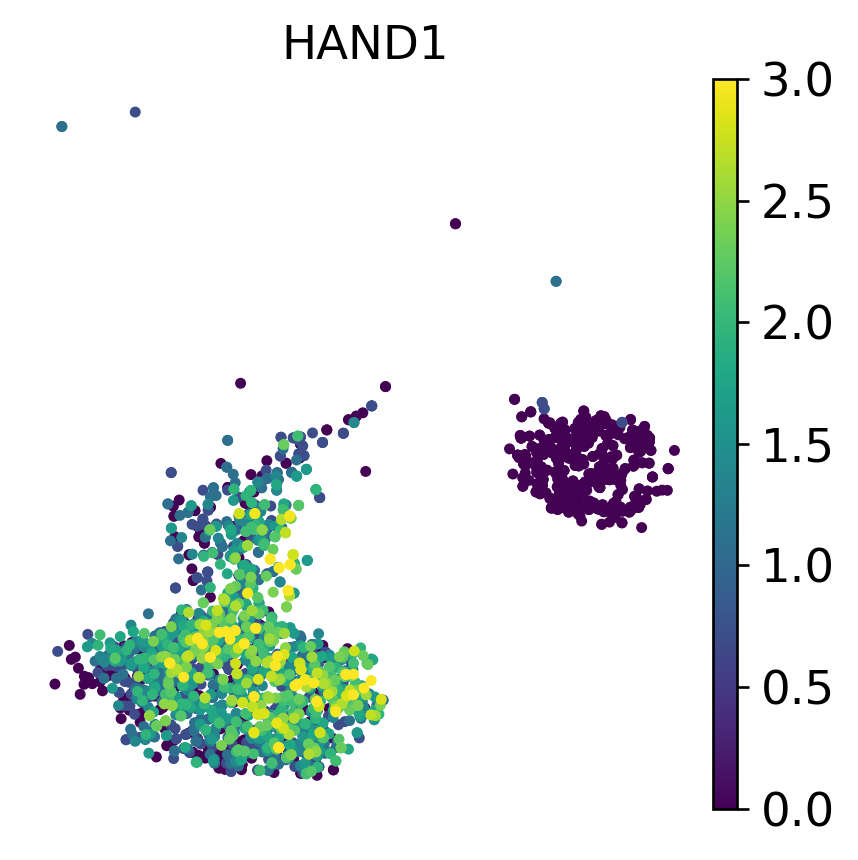

In [68]:
sc.pl.umap(X_cardiac_vae_ct, color="HAND1", vmin=0, vmax=3)

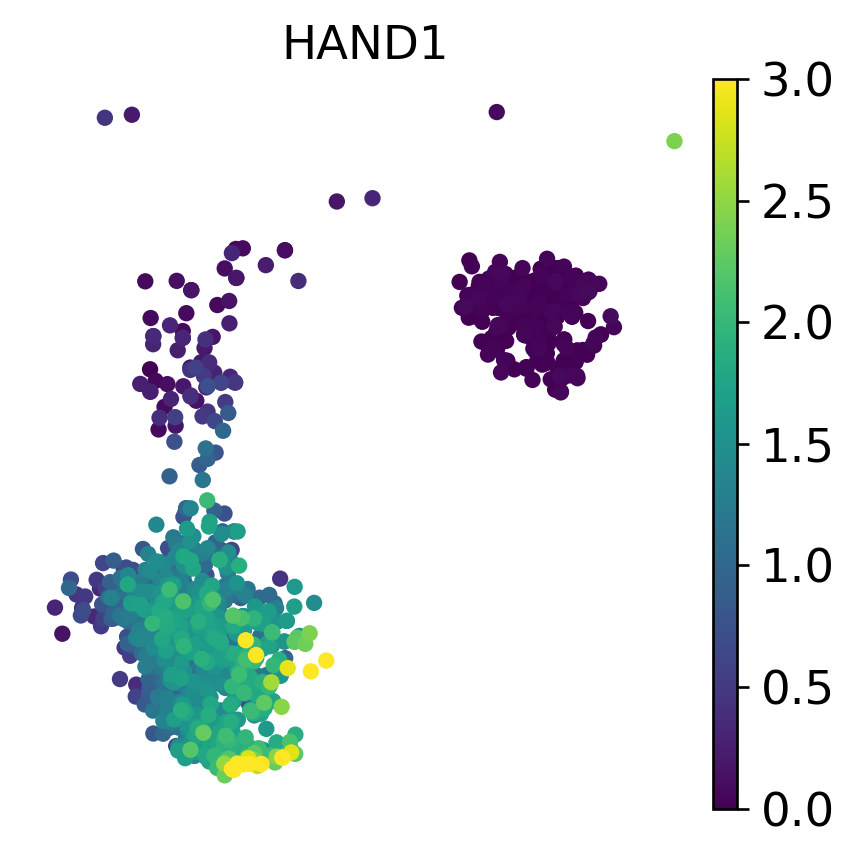

In [69]:
sc.pl.umap(X_cardiac_geodesic_ct, color="HAND1", vmin=0, vmax=3)

### Endoderm drivers

In [70]:
adata_eb_original_endoderm.var = adata_eb_original_endoderm.var.set_index("gene_name")
X_endoderm_flat_ct.var = adata_eb_original_endoderm.var
X_endoderm_vae_ct.var = adata_eb_original_endoderm.var
X_endoderm_geodesic_ct.var = adata_eb_original_endoderm.var

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/annda

### Neuronal drivers

In [71]:
adata_eb_original_neuronal.var = adata_eb_original_neuronal.var.set_index("gene_name")
X_neuronal_flat_ct.var = adata_eb_original_neuronal.var
X_neuronal_vae_ct.var = adata_eb_original_neuronal.var
X_neuronal_geodesic_ct.var = adata_eb_original_neuronal.var

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/annda

## Cardiac

In [82]:
for marker_c in ["GATA6", "GATA5", "HAND1", "TNNT2"]:
    print(marker_c)
    print(f"Real sparsity fraction: {(adata_eb_original_cardiac[:,marker_c].X.A<1e-2).sum() / len(adata_eb_original_cardiac)}")
    print(f"Flat sparsity fraction: {(X_cardiac_flat_ct[:,marker_c].X<1e-2).sum() / len(X_cardiac_flat_ct)}")
    print(f"VAE sparsity fraction: {(X_cardiac_vae_ct[:,marker_c].X<1e-2).sum() / len(X_cardiac_vae_ct)}")
    print(f"GAE sparsity fraction: {(X_cardiac_geodesic_ct[:,marker_c].X<1e-2).sum() / len(X_cardiac_geodesic_ct)}")
    print(f"VAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_cardiac_vae_ct[:,marker_c].X.squeeze()), np.array(adata_eb_original_cardiac[:,marker_c].X.A).squeeze())}")
    print(f"Flat wass fraction: {scipy.stats.wasserstein_distance(np.array(X_cardiac_flat_ct[:,marker_c].X.squeeze()), np.array(adata_eb_original_cardiac[:,marker_c].X.A).squeeze())}")
    print(f"GAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_cardiac_geodesic_ct[:,marker_c].X.squeeze()), np.array(adata_eb_original_cardiac[:,marker_c].X.A).squeeze())}")
    print()

GATA6
Real sparsity fraction: 0.8552631578947368
Flat sparsity fraction: 0.8580697485806975
VAE sparsity fraction: 0.8388027407140282
GAE sparsity fraction: 0.14606741573033707
VAE wass fraction: 0.026023211349213295
Flat wass fraction: 0.014966320967484341
GAE wass fraction: 0.16669763474839

GATA5
Real sparsity fraction: 0.9542464114832536
Flat sparsity fraction: 0.9407948094079481
VAE sparsity fraction: 0.9491525423728814
GAE sparsity fraction: 0.14285714285714285
VAE wass fraction: 0.008207063503990622
Flat wass fraction: 0.013808187165456991
GAE wass fraction: 0.06803669622528927

HAND1
Real sparsity fraction: 0.4647129186602871
Flat sparsity fraction: 0.45336577453365773
VAE sparsity fraction: 0.29715109989181393
GAE sparsity fraction: 0.15008025682182985
VAE wass fraction: 0.2387643895929329
Flat wass fraction: 0.09374270835178673
GAE wass fraction: 0.2879246339388083

TNNT2
Real sparsity fraction: 0.819377990430622
Flat sparsity fraction: 0.8491484184914841
VAE sparsity fractio

## Neural Crest

In [85]:
for marker_nc in ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"]:
    print(marker_nc)
    print(f"Real sparsity fraction: {(adata_eb_original_neural_crest[:,marker_nc].X.A<1e-2).sum() / len(adata_eb_original_neural_crest)}")
    print(f"Flat sparsity fraction: {(X_neural_crest_cells_flat_ct[:,marker_nc].X<1e-2).sum() / len(X_neural_crest_cells_flat_ct)}")
    print(f"VAE sparsity fraction: {(X_neural_crest_cells_vae_ct[:,marker_nc].X<1e-2).sum() / len(X_neural_crest_cells_vae_ct)}")
    print(f"GAE sparsity fraction: {(X_neural_crest_cells_geodesic_ct[:,marker_nc].X<1e-2).sum() / len(X_neural_crest_cells_vae_ct)}")
    print(f"VAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_neural_crest_cells_vae_ct[:,marker_nc].X.squeeze()), np.array(adata_eb_original_cardiac[:,marker_nc].X.A).squeeze())}")
    print(f"Flat wass fraction: {scipy.stats.wasserstein_distance(np.array(X_neural_crest_cells_flat_ct[:,marker_nc].X.squeeze()), np.array(adata_eb_original_cardiac[:,marker_nc].X.A).squeeze())}")
    print(f"GAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_neural_crest_cells_geodesic_ct[:,marker_nc].X.squeeze()), np.array(adata_eb_original_cardiac[:,marker_nc].X.A).squeeze())}")
    print()

NGFR
Real sparsity fraction: 0.9349729830445314
Flat sparsity fraction: 0.9687975646879756
VAE sparsity fraction: 0.9080246913580247
GAE sparsity fraction: 0.3015432098765432
VAE wass fraction: 0.06596316792034783
Flat wass fraction: 0.013781611879436944
GAE wass fraction: 0.052944370183250426

GYPC
Real sparsity fraction: 0.5013974287311347
Flat sparsity fraction: 0.5342465753424658
VAE sparsity fraction: 0.49506172839506174
GAE sparsity fraction: 0.014814814814814815
VAE wass fraction: 0.0870417828833649
Flat wass fraction: 0.05144277666424536
GAE wass fraction: 0.2424747688416422

CXCR4
Real sparsity fraction: 0.8587665362399851
Flat sparsity fraction: 0.8711314053779807
VAE sparsity fraction: 0.8635802469135803
GAE sparsity fraction: 0.09197530864197531
VAE wass fraction: 0.07731230568869782
Flat wass fraction: 0.07589941987450839
GAE wass fraction: 0.12784370259700187

PDGFRB
Real sparsity fraction: 0.985653065027017
Flat sparsity fraction: 0.9680365296803652
VAE sparsity fraction

## Endoderm

In [74]:
for marker_e in ["SOX17", "FOXA2", "CDX2", "GATA3"]:
    print(marker_e)
    print(f"Real sparsity fraction: {(adata_eb_original_endoderm[:,marker_e].X.A==0).sum() / len(adata_eb_original_endoderm)}")
    print(f"VAE sparsity fraction: {(X_endoderm_vae_ct[:,marker_e].X==0).sum() / len(X_endoderm_vae_ct)}")
    print(f"Flat sparsity fraction: {(X_endoderm_flat_ct[:,marker_e].X==0).sum() / len(X_endoderm_flat_ct)}")
    print(f"GAE sparsity fraction: {(X_endoderm_geodesic_ct[:,marker_e].X==0).sum() / len(X_endoderm_flat_ct)}")
    print(f"VAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_endoderm_vae_ct[:,marker_e].X.squeeze()), np.array(adata_eb_original_endoderm[:,marker_e].X.A).squeeze())}")
    print(f"Flat wass fraction: {scipy.stats.wasserstein_distance(np.array(X_endoderm_flat_ct[:,marker_e].X.squeeze()), np.array(adata_eb_original_endoderm[:,marker_e].X.A).squeeze())}")
    print(f"GAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_endoderm_geodesic_ct[:,marker_e].X.squeeze()), np.array(adata_eb_original_endoderm[:,marker_e].X.A).squeeze())}")
    print()

SOX17
Real sparsity fraction: 0.894456289978678
VAE sparsity fraction: 0.8249594813614263
Flat sparsity fraction: 0.9498207885304659
GAE sparsity fraction: 0.0
VAE wass fraction: 0.08187399359969305
Flat wass fraction: 0.07641793327141237
GAE wass fraction: 0.24162074608741013

FOXA2
Real sparsity fraction: 0.9464285714285714
VAE sparsity fraction: 0.9473257698541329
Flat sparsity fraction: 0.9689366786140979
GAE sparsity fraction: 0.0
VAE wass fraction: 0.005764971781197405
Flat wass fraction: 0.018381988904977123
GAE wass fraction: 0.07562535167432267

CDX2
Real sparsity fraction: 0.9312366737739872
VAE sparsity fraction: 0.9181523500810372
Flat sparsity fraction: 0.954599761051374
GAE sparsity fraction: 0.0
VAE wass fraction: 0.016389431193244056
Flat wass fraction: 0.023257273174512146
GAE wass fraction: 0.11448512750364014

GATA3
Real sparsity fraction: 0.9051172707889126
VAE sparsity fraction: 0.8444084278768234
Flat sparsity fraction: 0.937873357228196
GAE sparsity fraction: 0.0

## Neuronal

In [75]:
for marker_neu in ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1","NR2F1"]:
    print(marker_neu)
    print(f"Real sparsity fraction: {(adata_eb_original_neuronal[:,marker_neu].X.A==0).sum() / len(adata_eb_original_neuronal)}")
    print(f"Flat sparsity fraction: {(X_neuronal_flat_ct[:,marker_neu].X==0).sum() / len(X_neuronal_flat_ct)}")
    print(f"VAE sparsity fraction: {(X_neuronal_vae_ct[:,marker_neu].X==0).sum() / len(X_neuronal_vae_ct)}")
    print(f"GAE sparsity fraction: {(X_neuronal_geodesic_ct[:,marker_neu].X==0).sum() / len(X_neuronal_vae_ct)}")
    print(f"VAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_neuronal_vae_ct[:,marker_neu].X.squeeze()), np.array(adata_eb_original_neuronal[:,marker_neu].X.A).squeeze())}")
    print(f"Flat wass fraction: {scipy.stats.wasserstein_distance(np.array(X_neuronal_flat_ct[:,marker_neu].X.squeeze()), np.array(adata_eb_original_neuronal[:,marker_neu].X.A).squeeze())}")
    print(f"GAE wass fraction: {scipy.stats.wasserstein_distance(np.array(X_neuronal_geodesic_ct[:,marker_neu].X.squeeze()), np.array(adata_eb_original_neuronal[:,marker_neu].X.A).squeeze())}")
    print()

LMX1A
Real sparsity fraction: 0.9691113028472821
Flat sparsity fraction: 0.9555555555555556
VAE sparsity fraction: 1.0
GAE sparsity fraction: 0.0
VAE wass fraction: 0.024836695003962118
Flat wass fraction: 0.014722769351947666
GAE wass fraction: 0.04367395783664592

ISL1
Real sparsity fraction: 0.987230371009491
Flat sparsity fraction: 0.9777777777777777
VAE sparsity fraction: 0.9247311827956989
GAE sparsity fraction: 0.0
VAE wass fraction: 0.06329998265788156
Flat wass fraction: 0.01951606355421091
GAE wass fraction: 0.043234267555831124

DLX1
Real sparsity fraction: 0.9967213114754099
Flat sparsity fraction: 0.9777777777777777
VAE sparsity fraction: 0.978494623655914
GAE sparsity fraction: 0.0
VAE wass fraction: 0.014068947083340408
Flat wass fraction: 0.014565826784031915
GAE wass fraction: 0.013118152151635953

CXCR4
Real sparsity fraction: 0.8514236410698879
Flat sparsity fraction: 0.8666666666666667
VAE sparsity fraction: 0.7849462365591398
GAE sparsity fraction: 0.0
VAE wass fra